# Crop Yield Prediction - Deep Learning

We pass seasonal time series of WOFOST, weather and FAPAR to 1DCNN or LSTM layers to extract features from them. Learned seasonal features, yield trend features (yield values of 5 previous years) and static features are passed to the output layer.

In [ ]:
test_env = 'notebook'
if (test_env == 'notebook'):
  !pip install d2l==0.16.1 >/dev/null
  !pip install captum >/dev/null

  from d2l import torch as d2l
  import numpy as np
  import torch
  from torch import nn
  import pandas as pd
  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.rcParams['figure.figsize'] = [30,25]
  plt.rcParams.update({'font.size': 12})

  !pip install pyspark > /dev/null
  !sudo apt update > /dev/null
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  !pip install joblibspark > /dev/null

  import os
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
else:  
  import findspark
  findspark.init()

import pyspark
from pyspark.sql import functions as SparkF
from pyspark.sql import types as SparkT

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

SparkContext.setSystemProperty('spark.executor.memory', '12g')
SparkContext.setSystemProperty('spark.driver.memory', '6g')
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# crop name to id mapping
crop_id_dict = {
    'grain maize': 2,
    'sugar beet' : 6,
    'sugarbeet' : 6,
    'sugarbeets' : 6,
    'sugar beets' : 6,
    'total potatoes' : 7,
    'potatoes' : 7,
    'potato' : 7,
    'winter wheat' : 90,
    'soft wheat' : 90,
    'sunflower' : 93,
    'spring barley' : 95,
}

# crop id to name mapping
crop_name_dict = {
    2 : 'grain maize',
    6 : 'sugarbeet',
    7 : 'potatoes',
    90 : 'soft wheat',
    93 : 'sunflower',
    95 : 'spring barley',
}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 8.4 MB/s 




## Utility Functions

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error

import captum
from captum.attr import Occlusion
from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import DeepLiftShap
from captum.attr import GradientShap

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

# crop name and id mappings
def cropNameToID(crop_id_dict, crop):
  """
  Return id of given crop. Relies on crop_id_dict.
  Return 0 if crop name is not in the dictionary.
  """
  crop_lcase = crop.lower()
  try:
    crop_id = crop_id_dict[crop_lcase]
  except KeyError as e:
    crop_id = 0

  return crop_id

def cropIDToName(crop_name_dict, crop_id):
  """
  Return crop name for given crop ID. Relies on crop_name_dict.
  Return 'NA' if crop id is not found in the dictionary.
  """
  try:
    crop_name = crop_name_dict[crop_id]
  except KeyError as e:
    crop_name = 'NA'

  return crop_name

def getYear(date_str):
  """Extract year from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.year(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.year(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getMonth(date_str):
  """Extract month from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.month(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.month(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getDay(date_str):
  """Extract day from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.dayofmonth(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.dayofmonth(SparkF.to_date(date_str, 'dd/MM/yyyy')))

# 1-10: Dekad 1
# 11-20: Dekad 2
# > 20 : Dekad 3
def getDekad(date_str):
  """Extract dekad from date in YYYYMMDD format."""
  month = getMonth(date_str)
  day = getDay(date_str)
  return SparkF.when(day < 30, (month - 1)* 3 +
                     SparkF.ceil(day/10)).otherwise((month - 1) * 3 + 3)

def getFilename(crop, yield_trend, early_season_end,
                country=None, nuts_level=None, architecture=None):
  """Get filename based on input arguments"""
  filename = crop.replace(' ', '_')

  if (country is not None):
    filename += '_' + country

  if (nuts_level is not None):
    filename += '_' + nuts_level

  if (yield_trend):
    filename += '_trend'
  else:
    filename += '_notrend'

  if (early_season_end < 0):
    filename += '_early' + str(early_season_end)

  if (architecture is not None):
    filename += '-' + architecture

  return filename

def getLogFilename(crop, yield_trend, early_season_end,
                   country=None, nuts_level=None, architecture=None):
  """Get filename for experiment log"""
  log_file = getFilename(crop, yield_trend, early_season_end, country,
                         nuts_level, architecture)
  return log_file + '.log'

def getPredictionFilename(crop, yield_trend, early_season_end,
                          country=None, nuts_level=None, architecture=None):
  """Get unique filename for predictions"""
  pred_file = 'pred_'
  suffix = getFilename(crop, yield_trend, early_season_end, country,
                       nuts_level, architecture)
  pred_file += suffix
  return pred_file

def getFeatureImportanceFilename(crop, yield_trend, early_season_end,
                                 country=None, nuts_level=None, architecture=None):
  ft_import_file = 'import_'
  suffix = getFilename(crop, yield_trend, early_season_end, country,
                       nuts_level, architecture)
  return ft_import_file + suffix

def printConfig(cyp_config, log_fh=None):
  config_str = '\nCurrent DL Configuration'
  config_str += '\n-------------------------'
  for k in cyp_config:
    conf_val = cyp_config[k]
    if (not isinstance(conf_val, str)):
      conf_val = str(conf_val)

    config_str += '\n' + k + ': ' + conf_val

  config_str += '\n'
  if (log_fh is not None):
    log_fh.write(config_str)

  print(config_str)

def printPreprocessingInformation(df, data_source, order_cols, crop_season=None):
  """Print preprocessed data and additional debug information"""
  df_regions = [reg[0] for reg in df.select('IDREGION').distinct().collect()]
  print(data_source , 'data available for', len(df_regions), 'region(s)')
  if (crop_season is not None):
    print('Season end information')
    crop_season.orderBy(['IDREGION', 'FYEAR']).show(10)

  print(data_source, 'data')
  df.orderBy(order_cols).show(10)

def getTrendWindowYields(df, trend_window):
  """Extract previous years' yield values to separate columns"""
  sel_cols = ['IDREGION', 'FYEAR', 'YIELD']
  my_window = Window.partitionBy('IDREGION').orderBy('FYEAR')

  yield_fts = df.select(sel_cols)
  for i in range(trend_window):
    yield_fts = yield_fts.withColumn('YIELD-' + str(i+1),
                                     SparkF.lag(yield_fts.YIELD, i+1).over(my_window))
    yield_fts = yield_fts.withColumn('YEAR-' + str(i+1),
                                     SparkF.lag(yield_fts.FYEAR, i+1).over(my_window))

  # drop columns withs null values
  for i in range(trend_window):
    yield_fts = yield_fts.filter(SparkF.col('YIELD-' + str(i+1)).isNotNull())

  prev_yields = [ 'YIELD-' + str(i) for i in range(trend_window, 0, -1)]
  prev_years = [ 'YEAR-' + str(i) for i in range(trend_window, 0, -1)]
  sel_cols = ['IDREGION', 'FYEAR'] + prev_years + prev_yields
  yield_fts = yield_fts.select(sel_cols)

  return yield_fts

def getNumericIDSforNUTSIDs(src_df, nuts_id_col, num_id_col):
  """Assigns monotonically increasing unique ids to NUTS regions"""
  id_df = src_df.select(nuts_id_col).distinct().orderBy(nuts_id_col)
  id_df = id_df.withColumn(num_id_col, SparkF.monotonically_increasing_id())

  return id_df

def NormalizedRMSE(y_true, y_pred):
  y_true = y_true.astype('float32')
  y_pred = y_pred.astype('float32')
  return 100 * np.sqrt(mean_squared_error(y_true, y_pred))/np.mean(y_true)

## Data Preprocessor Class

In [ ]:
from pyspark.sql import Window

class CYPDataPreprocessor:
  def __init__(self, spark):
    self.spark = spark
    self.verbose = 1

  def extractYearDekad(self, df):
    """Extract year and dekad from date_col in yyyyMMdd format."""
    # Conversion to string type is required to make getYear(), getMonth() etc. work correctly.
    # They use to_date() function to verify valid dates and to_date() expects the date column to be string.
    df = df.withColumn('DATE', df['DATE'].cast("string"))
    df = df.select('*',
                   getYear('DATE').alias('FYEAR'),
                   getDekad('DATE').alias('DEKAD'))

    # Bring FYEAR, DEKAD to the front
    col_order = df.columns[:2] + df.columns[-2:] + df.columns[2:-2]
    df = df.select(col_order).drop('DATE')
    return df

  def getCropSeasonInformation(self, wofost_df, season_crosses_calyear):
    """Crop season information based on WOFOST DVS"""
    join_cols = ['IDREGION', 'FYEAR']
    if (('DATE' in wofost_df.columns) and ('FYEAR' not in wofost_df.columns)):
      wofost_df = self.extractYearDekad(wofost_df)

    crop_season = wofost_df.select(join_cols).distinct()
    diff_window = Window.partitionBy(join_cols).orderBy('DEKAD')
    cs_window = Window.partitionBy('IDREGION').orderBy('FYEAR')

    wofost_df = wofost_df.withColumn('VALUE', wofost_df['DVS'])
    wofost_df = wofost_df.withColumn('PREV', SparkF.lag(wofost_df['VALUE']).over(diff_window))
    wofost_df = wofost_df.withColumn('DIFF', SparkF.when(SparkF.isnull(wofost_df['PREV']), 0)\
                                     .otherwise(wofost_df['VALUE'] - wofost_df['PREV']))
    # calculate end of season dekad
    dvs_nochange_filter = ((wofost_df['VALUE'] >= 200) & (wofost_df['DIFF'] == 0.0))
    year_end_filter = (wofost_df['DEKAD'] == 36)
    if (season_crosses_calyear):
      value_zero_filter =  (wofost_df['VALUE'] == 0)
    else:
      value_zero_filter =  ((wofost_df['PREV'] >= 200) & (wofost_df['VALUE'] == 0))

    end_season_filter = (dvs_nochange_filter | value_zero_filter | year_end_filter)
    crop_season = crop_season.join(wofost_df.filter(end_season_filter).groupBy(join_cols)\
                                   .agg(SparkF.min('DEKAD').alias('SEASON_END_DEKAD')), join_cols)
    wofost_df = wofost_df.drop('VALUE', 'PREV', 'DIFF')

    # We take the max of SEASON_END_DEKAD for current campaign and next campaign
    # to determine which dekads go to next campaign year.
    max_year = crop_season.agg(SparkF.max('FYEAR')).collect()[0][0]
    min_year = crop_season.agg(SparkF.min('FYEAR')).collect()[0][0]
    crop_season = crop_season.withColumn('NEXT_SEASON_END', SparkF.when(crop_season['FYEAR'] == max_year,
                                                                        crop_season['SEASON_END_DEKAD'])\
                                         .otherwise(SparkF.lead(crop_season['SEASON_END_DEKAD']).over(cs_window)))
    crop_season = crop_season.withColumn('SEASON_END',
                                         SparkF.when(crop_season['SEASON_END_DEKAD'] > crop_season['NEXT_SEASON_END'],
                                                     crop_season['SEASON_END_DEKAD'])\
                                         .otherwise(crop_season['NEXT_SEASON_END']))
    crop_season = crop_season.withColumn('PREV_SEASON_END', SparkF.when(crop_season['FYEAR'] == min_year, 0)\
                                         .otherwise(SparkF.lag(crop_season['SEASON_END']).over(cs_window)))
    crop_season = crop_season.select(join_cols + ['PREV_SEASON_END', 'SEASON_END'])

    return crop_season

  def alignDataToCropSeason(self, df, crop_season, season_crosses_calyear):
    """Calculate CAMPAIGN_YEAR, CAMPAIGN_DEKAD based on crop_season"""
    join_cols = ['IDREGION', 'FYEAR']
    max_year = crop_season.agg(SparkF.max('FYEAR')).collect()[0][0]
    min_year = crop_season.agg(SparkF.min('FYEAR')).collect()[0][0]
    df = df.join(crop_season, join_cols)

    # Dekads > SEASON_END belong to next campaign year
    df = df.withColumn('CAMPAIGN_YEAR',
                       SparkF.when(df['DEKAD'] > df['SEASON_END'], df['FYEAR'] + 1)\
                       .otherwise(df['FYEAR']))
    # min_year has no previous season information. We align CAMPAIGN_DEKAD to end in 36.
    # For other years, dekads < SEASON_END are adjusted based on PREV_SEASON_END.
    # Dekads > SEASON_END get renumbered from 1 (for next campaign).
    df = df.withColumn('CAMPAIGN_DEKAD',
                       SparkF.when(df['CAMPAIGN_YEAR'] == min_year, df['DEKAD'] + 36 - df['SEASON_END'])\
                       .otherwise(SparkF.when(df['DEKAD'] > df['SEASON_END'], df['DEKAD'] - df['SEASON_END'])\
                                  .otherwise(df['DEKAD'] + 36 - df['PREV_SEASON_END'])))

    # Columns should be IDREGION, FYEAR, DEKAD, ..., CAMPAIGN_YEAR, CAMPAIGN_DEKAD.
    # Bring CAMPAIGN_YEAR and CAMPAIGN_DEKAD to the front.
    col_order = df.columns[:3] + df.columns[-2:] + df.columns[3:-2]
    df = df.select(col_order)
    if (season_crosses_calyear):
      # For crop with two seasons, remove the first year. Data from the first year
      # only contributes to the second year and we have already moved useful data
      # to the second year (or first campaign year).
      df = df.filter(df['CAMPAIGN_YEAR'] > min_year)

    # In both cases, remove extra rows beyond max campaign year
    df = df.filter(df['CAMPAIGN_YEAR'] <= max_year)
    return df

  def preprocessWofost(self, wofost_df, crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date. Use crop_season to compute
    CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    """
    if (('DATE' in wofost_df.columns) and ('FYEAR' not in wofost_df.columns)):
      wofost_df = self.extractYearDekad(wofost_df)

    join_cols = ['IDREGION', 'FYEAR']
    wofost_df = self.alignDataToCropSeason(wofost_df, crop_season, season_crosses_calyear)

    # determine when DVS becomes zero again
    start_season_df = wofost_df.filter((wofost_df['DEKAD'] > wofost_df['SEASON_END']) &
                                       (wofost_df['DVS'] == 0.0)).groupBy(['IDREGION', 'CAMPAIGN_YEAR'])\
                                .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_SEASON'))
    # start_season_df.orderBy(['IDREGION', 'CAMPAIGN_YEAR']).show()
    wofost_df = wofost_df.join(start_season_df, ['IDREGION', 'CAMPAIGN_YEAR'])
    # trailing columns: crop_season cols except join_cols, START_SEASON
    drop_cols = crop_season.columns[2:] + ['START_SEASON']
    num_trailing_cols = len(crop_season.columns) - 2 + 1
    wofost_inds = wofost_df.columns[5:-num_trailing_cols]
    # set indicators values for dekads after end of season to zero.
    # TODO - Dilli: Find a way to avoid the for loop.
    for ind in wofost_inds:
        wofost_df = wofost_df.withColumn(ind,
                                         SparkF.when(wofost_df['CAMPAIGN_DEKAD'] >= wofost_df['START_SEASON'],
                                                     wofost_df[ind]).otherwise(0))

    wofost_df = wofost_df.drop(*drop_cols)
    return wofost_df

  def preprocessMeteo(self, meteo_df, crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date, calculate CWB.
    Use crop_season to compute CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    """
    join_cols = ['IDREGION', 'FYEAR']
    drop_cols = crop_season.columns[2:]
    meteo_df = meteo_df.drop('IDCOVER')
    meteo_df = meteo_df.withColumn('CWB',
                                   SparkF.bround(meteo_df['PREC'] - meteo_df['ET0'], 2))
    if (('DATE' in meteo_df.columns) and ('FYEAR' not in meteo_df.columns)):
      meteo_df = self.extractYearDekad(meteo_df)

    meteo_df = self.alignDataToCropSeason(meteo_df, crop_season, season_crosses_calyear)
    
    meteo_df = meteo_df.drop(*drop_cols)
    return meteo_df

  def preprocessMeteoDaily(self, meteo_df):
    """
    Convert daily meteo data to dekadal. Takes avg for all indicators
    except TMAX (take max), TMIN (take min), PREC (take sum), ET0 (take sum), CWB (take sum).
    """
    self.spark.catalog.dropTempView('meteo_daily')
    meteo_df.createOrReplaceTempView('meteo_daily')
    join_cols = ['IDREGION', 'CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']
    join_df = meteo_df.select(join_cols + ['FYEAR', 'DEKAD']).distinct()

    # We are ignoring VPRES, WSPD and RELH at the moment
    # avg(VPRES) as VPRES1, avg(WSPD) as WSPD1, avg(RELH) as RELH1,
    # TMAX| TMIN| TAVG| VPRES| WSPD| PREC| ET0| RAD| RELH| CWB
    #
    # It seems keeping same name after aggregation is fine. We are using a
    # different name just to be sure nothing untoward happens.
    query = 'select IDREGION, CAMPAIGN_YEAR, CAMPAIGN_DEKAD, '
    query = query + ' max(TMAX) as TMAX1, min(TMIN) as TMIN1, '
    query = query + ' bround(avg(TAVG), 2) as TAVG1, bround(sum(PREC), 2) as PREC1, '
    query = query + ' bround(sum(ET0), 2) as ET01, bround(avg(RAD), 2) as RAD1, '
    query = query + ' bround(sum(CWB), 2) as CWB1 '
    query = query + ' from meteo_daily group by IDREGION, CAMPAIGN_YEAR, CAMPAIGN_DEKAD '
    query = query + ' order by IDREGION, CAMPAIGN_YEAR, CAMPAIGN_DEKAD'
    meteo_df = self.spark.sql(query).cache()

    # rename the columns
    selected_cols = ['TMAX', 'TMIN', 'TAVG', 'PREC', 'ET0', 'RAD', 'CWB']
    for scol in selected_cols:
      meteo_df = meteo_df.withColumnRenamed(scol + '1', scol)

    meteo_df = meteo_df.join(join_df, join_cols)
    # Bring FYEAR, DEKAD to the front
    col_order = meteo_df.columns[:1] + meteo_df.columns[-2:] + meteo_df.columns[1:-2]
    meteo_df = meteo_df.select(col_order)

    return meteo_df

  def preprocessRemoteSensing(self, rs_df, crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date.
    Use crop_season to compute CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    NOTE crop_season and rs_df must be at the same NUTS level.
    """
    join_cols = ['IDREGION', 'FYEAR']
    drop_cols = crop_season.columns[2:]
    if (('DATE' in rs_df.columns) and ('FYEAR' not in rs_df.columns)):
      rs_df = self.extractYearDekad(rs_df)

    rs_df = self.alignDataToCropSeason(rs_df, crop_season, season_crosses_calyear)
    rs_df = rs_df.drop(*drop_cols)
    return rs_df

  def preprocessSoil(self, soil_df):
    # SM_WC = water holding capacity
    soil_df = soil_df.withColumn('SM_WHC', SparkF.bround(soil_df['SM_FC'] - soil_df['SM_WP'], 2))
    soil_df = soil_df.select(['IDREGION', 'SM_WHC'])

    return soil_df

  def preprocessAreaFractions(self, af_df, crop_id):
    """Filter area fractions data by crop id"""
    af_df = af_df.withColumn("FYEAR", af_df["FYEAR"].cast(SparkT.IntegerType()))
    af_df = af_df.filter(af_df["CROP_ID"] == crop_id).drop('CROP_ID')

    return af_df

  def preprocessCropArea(self, area_df, crop_id):
    """Filter area fractions data by crop id"""
    area_df = area_df.withColumn("FYEAR", area_df["FYEAR"].cast(SparkT.IntegerType()))
    area_df = area_df.filter(area_df["CROP_ID"] == crop_id).drop('CROP_ID')
    area_df = area_df.filter(area_df["CROP_AREA"].isNotNull())
    area_df = area_df.drop('FRACTION')

    return area_df

  def preprocessGAES(self, gaes_df, crop_id):
    """Select irrigated crop area by crop id"""
    sel_cols = [ c for c in gaes_df.columns if 'IRRIG' not in c]
    sel_cols += ['IRRIG_AREA_ALL', 'IRRIG_AREA' + str(crop_id)]

    return gaes_df.select(sel_cols)

  def preprocessLabels(self, yield_df, crop_id):
    """
    Yield preprocessing depends on the data format.
    Here we cover preprocessing for France (NUTS3), Germany (NUTS3) and the Netherlands (NUTS2).
    """
    # Delete trailing empty columns
    empty_cols = [ c for c in yield_df.columns if c.startswith('_c') ]
    for c in empty_cols:
      yield_df = yield_df.drop(c)

    # Special case for Netherlands and Germany: convert yield columns into rows
    years = [int(c) for c in yield_df.columns if c[0].isdigit()]
    if (len(years) > 0):
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], cropNameToID(crop_id_dict, x[0]), x[1],
                                                  [(years[i], x[i+2]) for i in range(len(years))]))

      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', 'IDREGION', 'YIELD'])
      yield_df = yield_df.withColumn('YR_YIELD', SparkF.explode('YIELD')).drop('YIELD')
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], x[1], x[2], x[3][0], x[3][1]))
      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', 'IDREGION', 'FYEAR', 'YIELD'])
    else:
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], cropNameToID(crop_id_dict, x[0]), x[1], x[2], x[3]))
      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', 'IDREGION', 'FYEAR', 'YIELD'])

    yield_df = yield_df.filter(yield_df.CROP_ID == crop_id).drop('CROP', 'CROP_ID')
    if (yield_df.count() == 0):
      return None

    yield_df = yield_df.filter(yield_df.YIELD.isNotNull())
    yield_df = yield_df.withColumn("YIELD", yield_df["YIELD"].cast(SparkT.FloatType()))
    yield_df = yield_df.withColumn("FYEAR", yield_df["FYEAR"].cast(SparkT.IntegerType()))
    yield_df = yield_df.filter(yield_df['YIELD'] > 0.0)

    return yield_df

## Data Loading and Preprocessing

In [ ]:
from datetime import date
from pyspark.sql import Window

def loadDataFromCSVFile(spark, data_path, src, nuts, country_code):
    """
    The implied filename for each source is:
    <data_source>_<nuts_level>_<country_code>.csv
    Examples: WOFOST_NUTS2_NL.csv.
    Schema is inferred from the file. We might want to specify the schema at some point.
    """
    if (country_code is not None):
      datafile = data_path + '/' + src  + '_' + nuts + '_' + country_code + '.csv'
    elif (nuts is not None):
      datafile = data_path + '/' + src  + '_' + nuts + '.csv'
    else:
      datafile = data_path + '/' + src  + '.csv'

    print('Data file name', '"' + datafile + '"')

    df = spark.read.csv(datafile, header = True, inferSchema = True)
    return df

def loadAllData(spark, data_sources, data_path='.', country=None):
  #################
  # Load data     #
  #################
  data_dfs = {}
  for src in data_sources:
    nuts_level = None
    if (country is not None):
      nuts_level = data_sources[src]['nuts_level']

    data_dfs[src] = loadDataFromCSVFile(spark, data_path, src, nuts_level, country)

  data_sources_str = ''
  for src in data_dfs:
    data_sources_str = data_sources_str + src + ', '

  # remove the comma and space from the end
  print('Loaded data:', data_sources_str[:-2])
  print('\n')

  return data_dfs

def preprocessData(spark, data_dfs, data_sources, crop,
                   season_crosses_calyear=False,
                   early_season=False, early_season_end=0, print_debug=False):
  ######################
  # Preprocess Data    #
  ######################
  crop_id = cropNameToID(crop_id_dict, crop)
  cyp_preprocessor = CYPDataPreprocessor(spark)
  crop_season = None
  label_nuts_level = data_sources['YIELD']['nuts_level']
  for src in data_sources:
    if (src == 'WOFOST'):
      # wofost data
      wofost_df = data_dfs[src]
      wofost_df = wofost_df.filter(wofost_df['CROP_ID'] == crop_id).drop('CROP_ID')
      crop_season = cyp_preprocessor.getCropSeasonInformation(wofost_df, season_crosses_calyear)
      wofost_df = cyp_preprocessor.preprocessWofost(wofost_df, crop_season, season_crosses_calyear)
      wofost_regions = [reg[0] for reg in wofost_df.select('IDREGION').distinct().collect()]
      data_dfs[src] = wofost_df

    if ('METEO' in src):
      # meteo data
      meteo_df = data_dfs[src]
      meteo_df = cyp_preprocessor.preprocessMeteo(meteo_df, crop_season, season_crosses_calyear)

      if (src == 'METEO_DAILY'):
        meteo_df = cyp_preprocessor.preprocessMeteoDaily(meteo_df)

      # Make CWB a cumulative sum
      # We limit counting to 4 months before emergence.
      w = Window.partitionBy(['IDREGION', 'CAMPAIGN_YEAR']).orderBy('CAMPAIGN_DEKAD')\
                                                           .rangeBetween(Window.unboundedPreceding, 0)
      if (crop == 'soft wheat'):
        after_season_start = (meteo_df['CAMPAIGN_DEKAD'] >= 1)
      elif (crop == 'grain maize'):
        after_season_start = (meteo_df['CAMPAIGN_DEKAD'] >= 7)
      # TODO: add filter for other crops
      else:
        after_season_start = (meteo_df['CAMPAIGN_DEKAD'] >= 1)

      meteo_df = meteo_df.withColumn('CWB', SparkF.sum(SparkF.when(after_season_start, meteo_df['CWB'])\
                                                             .otherwise(0.0)).over(w))

      assert (meteo_df is not None)
      data_dfs[src] = meteo_df

    # remote sensing data
    if (src == 'REMOTE_SENSING'):
      rs_df = data_dfs[src]
      rs_df = rs_df.drop('IDCOVER')
      rs_df = cyp_preprocessor.preprocessRemoteSensing(rs_df, crop_season, season_crosses_calyear)
      assert (rs_df is not None)
      data_dfs[src] = rs_df

    # soil data
    if (src == 'SOIL'):
      soil_df = data_dfs['SOIL']
      soil_df = cyp_preprocessor.preprocessSoil(soil_df)
      data_dfs['SOIL'] = soil_df

    # agro-environmental zones
    if (src == 'GAES'):
      gaes_df = data_dfs['GAES']
      gaes_df = cyp_preprocessor.preprocessGAES(gaes_df, crop_id)
      data_dfs['GAES'] = gaes_df

    # crop area data
    if (src == 'CROP_AREA'):
      crop_area_df = data_dfs['CROP_AREA']
      crop_area_df = cyp_preprocessor.preprocessCropArea(crop_area_df, crop_id)
      data_dfs['CROP_AREA'] = crop_area_df

    # label data
    if (src == 'YIELD'):
      label_df = data_dfs['YIELD']

      label_df = cyp_preprocessor.preprocessLabels(label_df, crop_id)
      assert (label_df is not None)
      data_dfs['YIELD'] = label_df

  for src in data_dfs:
    order_cols = data_sources[src]['order_cols']
    src_df = data_dfs[src]
    if (print_debug):
      if (src == 'WOFOST'):
        printPreprocessingInformation(src_df, src, order_cols, crop_season=crop_season)
      else:
        printPreprocessingInformation(src_df, src, order_cols)

  return data_dfs

def wofostDVSSummary(wofost_df, early_season_end=None):
  """
  Summary of crop calendar based on DVS.
  Early season end is relative to end of the season, hence a negative number.
  """
  join_cols = ['IDREGION', 'CAMPAIGN_YEAR']
  dvs_summary = wofost_df.select(join_cols).distinct()
  wofost_df = wofost_df.withColumn('SEASON_ALIGN', wofost_df['CAMPAIGN_DEKAD'] - wofost_df['DEKAD'])

  dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] > 0.0).groupBy(join_cols)\
                                  .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_DVS')), join_cols)
  dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 100).groupBy(join_cols)\
                                  .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_DVS1')), join_cols)
  dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 200).groupBy(join_cols)\
                                  .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_DVS2')), join_cols)
  dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 200).groupBy(join_cols)\
                                  .agg(SparkF.min('DEKAD').alias('HARVEST')), join_cols)
  dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 200).groupBy(join_cols)\
                                  .agg(SparkF.max('SEASON_ALIGN').alias('SEASON_ALIGN')), join_cols)

  # Calendar year end season and early season dekads for comparing with MCYFS
  # Campaign year early season dekad to filter data during feature design
  dvs_summary = dvs_summary.withColumn('CALENDAR_END_SEASON', dvs_summary['HARVEST'] + 1)
  dvs_summary = dvs_summary.withColumn('CAMPAIGN_EARLY_SEASON',
                                        dvs_summary['CALENDAR_END_SEASON'] + dvs_summary['SEASON_ALIGN'])
  if (early_season_end is not None):
    dvs_summary = dvs_summary.withColumn('CALENDAR_EARLY_SEASON',
                                        dvs_summary['CALENDAR_END_SEASON'] + early_season_end)
    dvs_summary = dvs_summary.withColumn('CAMPAIGN_EARLY_SEASON',
                                          dvs_summary['CAMPAIGN_EARLY_SEASON'] + early_season_end)

  dvs_summary = dvs_summary.drop('HARVEST', 'SEASON_ALIGN')

  return dvs_summary

def getCropCalendar(pd_dvs_summary, early_season_end, log_fh):
  """Use DVS summary to infer the crop calendar"""
  avg_dvs_start = np.round(pd_dvs_summary['START_DVS'].mean(), 0)
  avg_dvs1_start = np.round(pd_dvs_summary['START_DVS1'].mean(), 0)
  avg_dvs2_start = np.round(pd_dvs_summary['START_DVS2'].mean(), 0)

  # We look at 6 windows
  # 0. Preplanting window (maximum of 4 months = 12 dekads).
  # Subtracting 11 because both ends of the period are included.
  p0_start = 1 if (avg_dvs_start - 11) < 1 else (avg_dvs_start - 11)
  p0_end = avg_dvs_start

  # 1. Planting window
  p1_start = avg_dvs_start - 1
  p1_end = avg_dvs_start + 1

  # 2. Vegetative phase
  p2_start = avg_dvs_start
  p2_end = avg_dvs1_start

  # 3. Flowering phase
  p3_start = avg_dvs1_start - 1
  p3_end = avg_dvs1_start + 1

  # 4. Yield formation phase
  p4_start = avg_dvs1_start
  p4_end = avg_dvs2_start

  # 5. Harvest window
  p5_start = avg_dvs2_start - 1
  p5_end = avg_dvs2_start + 1

  campaign_early_season_end = 36
  if (early_season_end < 0):
    campaign_early_season_end = np.round(pd_dvs_summary['CAMPAIGN_EARLY_SEASON'].mean(), 0)
    p0_end = campaign_early_season_end if (p0_end > campaign_early_season_end) else p0_end
    p1_end = campaign_early_season_end if (p1_end > campaign_early_season_end) else p1_end
    p2_end = campaign_early_season_end if (p2_end > campaign_early_season_end) else p2_end
    p3_end = campaign_early_season_end if (p3_end > campaign_early_season_end) else p3_end
    p4_end = campaign_early_season_end if (p4_end > campaign_early_season_end) else p4_end
    p5_end = campaign_early_season_end if (p5_end > campaign_early_season_end) else p5_end

  crop_cal = {}
  if (p0_end > p0_start):
    crop_cal['p0'] = { 'desc' : 'pre-planting window', 'start' : p0_start, 'end' : p0_end }
  if (p1_end > p1_start):
    crop_cal['p1'] = { 'desc' : 'planting window', 'start' : p1_start, 'end' : p1_end }
  if (p2_end > p2_start):
    crop_cal['p2'] = { 'desc' : 'vegetative phase', 'start' : p2_start, 'end' : p2_end }
  if (p3_end > p3_start):
    crop_cal['p3'] = { 'desc' : 'flowering phase', 'start' : p3_start, 'end' : p3_end }
  if (p4_end > p4_start):
    crop_cal['p4'] = { 'desc' : 'yield formation phase', 'start' : p4_start, 'end' : p4_end }
  if (p5_end > p5_start):
    crop_cal['p5'] = { 'desc' : 'harvest window', 'start' : p5_start, 'end' : p5_end }

  if (early_season_end < 0):
    early_season_info = '\nEarly Season Prediction Dekad: ' + str(early_season_end)
    early_season_info += ', Campaign Dekad: ' + str(campaign_early_season_end)
    print(early_season_info)
    log_fh.write(early_season_info + '\n')

  crop_cal_info = '\nCrop Calendar'
  crop_cal_info += '\n-------------'
  for p in crop_cal:
    crop_cal_info += '\nPeriod ' + p + ' (' + crop_cal[p]['desc'] + '): '
    crop_cal_info += 'Campaign Dekads ' + str(crop_cal[p]['start']) + '-' + str(crop_cal[p]['end'])

  print(crop_cal_info)
  log_fh.write(crop_cal_info + '\n')

  return crop_cal

def printCropCalendar(wofost_df, early_season_end, log_fh):
  dvs_summary = wofostDVSSummary(wofost_df, early_season_end)
  print('Season End:', dvs_summary.agg(SparkF.avg('CALENDAR_END_SEASON')).collect()[0][0])
  dvs_summary = dvs_summary.drop('CALENDAR_END_SEASON', 'CALENDAR_EARLY_SEASON')
  dvs_summary.orderBy(['IDREGION', 'CAMPAIGN_YEAR']).show(10)
  crop_cal = getCropCalendar(dvs_summary.toPandas(), early_season_end, log_fh)

def combineInputData(data_sources, data_dfs,
                     ts_data_sources,
                     static_data_sources,
                     trend_window=5,
                     print_debug=False):
  """Combine dekadal and static data"""
  input_min_year = 1900
  input_max_year = date.today().year

  label_df = data_dfs['YIELD']
  crop_area_df = data_dfs['CROP_AREA']
  for src in ts_data_sources:
    input_df = data_dfs[src]
    min_year = input_df.agg(SparkF.min('CAMPAIGN_YEAR')).collect()[0][0]
    max_year = input_df.agg(SparkF.max('CAMPAIGN_YEAR')).collect()[0][0]
    # max of min years (earliest year after join, non min of min)
    if (min_year > input_min_year):
      input_min_year = min_year
    # min of max years (latest year after join, non max of max)
    if (max_year < input_max_year):
      input_max_year = max_year

  # combine dekadal data
  combined_dekadal_df = None
  for src in ts_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    input_df = input_df.filter((input_df['CAMPAIGN_YEAR'] >= input_min_year) &
                               (input_df['CAMPAIGN_YEAR'] <= input_max_year))
    if (combined_dekadal_df is None):
      combined_dekadal_df = input_df
    else:
      combined_dekadal_df = combined_dekadal_df.join(input_df, data_sources[src]['order_cols'], 'full')
      combined_dekadal_df = combined_dekadal_df.na.fill(0.0)

  combined_static_df = None
  for src in static_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    if (combined_static_df is None):
      combined_static_df = input_df
    else:
      combined_static_df = combined_static_df.join(input_df, ['IDREGION'])

  # get trend feature values: basically values of 5 previous years
  trend_ft_df = getTrendWindowYields(label_df, trend_window)
  year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
  trend_ft_df = trend_ft_df.drop(*year_cols)

  # Create numeric ids for regions and countries
  id_df = getNumericIDSforNUTSIDs(label_df, 'IDREGION', 'id3')
  id_df = id_df.withColumn('COUNTRY', SparkF.substring(id_df['IDREGION'], 1, 2))
  cnid_df = getNumericIDSforNUTSIDs(id_df, 'COUNTRY', 'id0')
  id_df = id_df.join(cnid_df, ['COUNTRY'])

  combined_dfs = {
      'DEKADAL' : combined_dekadal_df,
      'STATIC' : combined_static_df,
      'CROP_AREA' : crop_area_df,
      'YIELD_TREND' : trend_ft_df,
      'YIELD' : label_df,
  }

  # Add numeric id columns, remove IDREGION, COUNTRY and reorder columns
  num_id_cols = ['id0', 'id3']
  for src in combined_dfs:
    src_df = combined_dfs[src]
    src_df = src_df.join(id_df, ['IDREGION']).drop(*['IDREGION', 'COUNTRY'])
    col_order = num_id_cols + [c for c in src_df.columns if c not in num_id_cols]
    src_df = src_df.select(col_order)
    if (print_debug):
      print('\n', src)
      if (src == 'DEKADAL'):
        src_df.orderBy(num_id_cols + ['CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']).show(10)
      elif (src == 'STATIC'):
        src_df.orderBy(num_id_cols).show(10)
      else:
        src_df.orderBy(num_id_cols + ['FYEAR']).show(10)

    combined_dfs[src] = src_df.toPandas()

  if (print_debug):
    print('\n', 'NUMERIC_IDS')
    id_df.orderBy(num_id_cols).show(10)

  combined_dfs['NUMERIC_IDS'] = id_df.toPandas()
  return combined_dfs

## Training, Validation and Test Splits

In [ ]:
import numpy as np

class CYPTrainTestSplitter:
  def __init__(self, verbose=False):
    self.verbose = verbose

  def getTestYears(self, all_years, test_fraction=None, use_yield_trend=None):
    num_years = len(all_years)
    test_years = []
    if (test_fraction is None):
      test_fraction = 0.3

    if (use_yield_trend is None):
      use_yield_trend = False

    if (use_yield_trend):
      # If test_year_start 15, years with index >= 15 are added to the test set
      test_year_start = num_years - np.floor(num_years * test_fraction).astype('int')
      test_years = all_years[test_year_start:]
    else:
      # If test_year_pos = 5, every 5th year is added to test set.
      # indices start with 0, so test_year_pos'th year has index (test_year_pos - 1)
      test_year_pos = np.floor(1/test_fraction).astype('int')
      test_years = all_years[test_year_pos - 1::test_year_pos]

    return test_years

  # NOTE Y_train should include IDREGION, FYEAR as first two columns.
  def getCustomKFoldValidationYears(self, all_years, num_folds=5, num_valid_years=1):
    """
    Custom K-fold Validation Splits:
    When using yield trend, we cannot do k-fold cross-validation. The custom
    K-Fold validation splits data in time-ordered fashion. The test data
    always comes after the training data.
    """
    num_years = len(all_years)
    num_train_years = num_years - (num_valid_years * num_folds)

    custom_split_info = '\nCustom sliding validation train, test splits'
    custom_split_info += '\n----------------------------------------------'

    cv_valid_years = []
    for k in range(num_folds):
      test_years_start = num_train_years + (k * num_valid_years)
      k_train_years = all_years[:test_years_start]
      k_val_years = all_years[test_years_start:test_years_start + num_valid_years]
      cv_valid_years.append(k_val_years)
      k_train_years = [str(y) for y in k_train_years]
      k_val_years = [str(y) for y in k_val_years]
      custom_split_info += '\nValidation set ' + str(k + 1) + ' training years: ' + ', '.join(k_train_years)
      custom_split_info += '\nValidation set ' + str(k + 1) + ' test years: ' + ', '.join(k_val_years)

    custom_split_info += '\n'
    if (self.verbose):
      print(custom_split_info)

    return cv_valid_years

## Dataset Class

In [ ]:
from torch.utils.data import Dataset

# A dataset class for crop yield forecasting data
# A dataset class for crop yield forecasting data
class CYPMLDataset(Dataset):
  """
  Dataset class used to load features and labels for training and testing.
  For more info about writing custom datasets classes check
  https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

  Parameters
  ----------
  data_dfs : dictionary of input dataframes
  yield_trend : data uses yield trend
  early_season_end : early season prediction dekad (relative to harvest)
  is_train : bool to differentiate training, validation and test sets
  is_validation : bool to differentiate between training and validation sets
  test_fraction : fraction of years to use for held-out testing
  num_folds : number of folds for custom cv
  num_valid_years : number of years in validation set
  fold_iter : iteration number of cv
  scaler_args : mean, std values (for each indicator) calculated using training dataset
  country : country code
  """
  def __init__(self, data_dfs,
               yield_trend=True, early_season_end=None,
               is_train=True, is_validation=False, test_fraction=0.3,
               num_folds=1, num_valid_years=5, fold_iter=0,
               scaler_args=None, country=None, test_years=None,
               print_debug=False, log_fh=None):

    if (is_train and print_debug):
      print('\n----------------')
      print('Training data')
      print('----------------')
    elif (is_validation and print_debug):
      print('\n------------------')
      print('Validation data')
      print('------------------')
    elif (print_debug):
      print('\n-------------')
      print('Test data:')
      print('-------------')

    pd_dekadal_df = data_dfs['DEKADAL']
    pd_dekadal_df = pd_dekadal_df.rename(columns={ 'CAMPAIGN_YEAR' : 'FYEAR' })
    max_dekad = 36
    if (early_season_end is not None):
      # early_season_end is relative to harvest (so 0 or negative)
      max_dekad += early_season_end
      pd_dekadal_df = pd_dekadal_df[pd_dekadal_df['CAMPAIGN_DEKAD'] <= max_dekad]

    pd_label_df = data_dfs['YIELD']
    pd_trend_df = data_dfs['YIELD_TREND']
    pd_crop_area_df = data_dfs['CROP_AREA']
    pd_label_df = pd_label_df.merge(pd_crop_area_df, on=['id0', 'id3', 'FYEAR'])
    pd_static_df = data_dfs['STATIC']
    id_df = data_dfs['NUMERIC_IDS']

    static_exclude_cols = ['id0', 'id3', 'AEZ_ID']
    static_feature_cols = [ c for c in pd_static_df.columns if c not in static_exclude_cols]
    # Static data
    pd_label_df = pd_label_df.merge(pd_static_df[['id0', 'id3']], on=['id0', 'id3'])
    if (len(pd_static_df['id0'].unique()) > 1):
      pd_sel_static_df = pd_static_df[['id0', 'AEZ_ID']].astype({ 'id0' : 'str', 'AEZ_ID' : 'str' })
      pd_onehot_df = pd.get_dummies(pd_sel_static_df, prefix=['CN', 'AEZ'])
    else:
      pd_sel_static_df = pd_static_df[['AEZ_ID']].astype({ 'AEZ_ID' : 'str' })
      pd_onehot_df = pd.get_dummies(pd_sel_static_df, prefix=['AEZ'])

    pd_static_df = pd_static_df.drop(columns=['id0', 'AEZ_ID'])
    pd_static_df = pd.concat([pd_static_df, pd_onehot_df], axis=1)
    static_feature_cols += list(pd_onehot_df.columns.values)
    self.static_feature_cols = static_feature_cols
    static_sel_cols = ['id3'] + static_feature_cols

    # Dekadal data should have id0, id3, FYEAR, CAMPAIGN_DEKAD, ...
    dekadal_feature_cols = list(pd_dekadal_df.columns.values)[4:]
    # Trend data should have id0, id3, FYEAR, ...
    trend_feature_cols = list(pd_trend_df.columns.values)[3:]
    # For labels, we want to keep id0, id3 and FYEAR.
    label_cols = list(pd_label_df.columns.values[:-1])

    if (print_debug):
      assert (log_fh is not None)
      feature_cols_info = '\n'
      feature_cols_info += '\nDekadal features: ' + ', '.join(dekadal_feature_cols)
      feature_cols_info += '\nOther features: ' + ', '.join(static_feature_cols)
      feature_cols_info += '\nTrend features: ' + ', '.join(trend_feature_cols)
      feature_cols_info += '\nLabel columns: ' + ', '.join(label_cols[3:])
      print(feature_cols_info)
      log_fh.write(feature_cols_info + '\n')

    # NOTE: Static features include one-hot enconding of countries and AEZs.
    # We need to create the encodings with all the countries and AEZs when
    # creating a dataset to finetune model for one country. The saved model
    # expects certain number of static features.
    country_codes = sorted(id_df['COUNTRY'].unique())
    if (country is not None):
      country_codes = [country]

    self.X_dekadal = None
    self.X_trend = None
    self.Y = None
    for cn in country_codes:
      cn_id = id_df[id_df['COUNTRY'] == cn]['id0'].values[0]
      pd_cn_label_df = pd_label_df[pd_label_df['id0'] == cn_id]
      pd_cn_trend_df = pd_trend_df[pd_trend_df['id0'] == cn_id]
      pd_cn_dekadal_df = pd_dekadal_df[pd_dekadal_df['id0'] == cn_id]

      cn_all_years = sorted(pd_cn_label_df['FYEAR'].unique())
      if (is_train or is_validation or (test_years is None)):
        # in the baseline, test years are determined based on all years available.
        select_years = self.selectYears(cn_all_years, is_train, is_validation, test_fraction,
                                        num_folds, num_valid_years, fold_iter,
                                        yield_trend)
      else:
        select_years = test_years

      min_trend_year = pd_cn_trend_df['FYEAR'].min()
      min_dek_year = pd_cn_dekadal_df['FYEAR'].min()
      if (is_train):
        # if using given test years, use all previous years for training
        if (test_years is not None):
          select_years = [ yr for yr in cn_all_years if yr < test_years[0]]

        # Filter earlier years not in trend and dekadal data.
        select_years = [ yr for yr in select_years if ((yr >= min_trend_year) and (yr >= min_dek_year))]

      if (is_train and print_debug):
        train_info = '\n' + cn + ' Training years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(train_info + '\n')
        print(train_info)
      elif (is_validation and print_debug):
        valid_info = '\n' + cn + ' Validation years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(valid_info + '\n')
        print(valid_info)
      elif (print_debug):
        test_info = '\n' + cn + ' Test years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(test_info + '\n')
        print(test_info)

      cn_regions = sorted(pd_cn_label_df['id3'].unique())
      for reg in cn_regions:
        for yr in select_years:
          sel_dekadal_df = pd_cn_dekadal_df[(pd_cn_dekadal_df['id3'] == reg) &
                                            (pd_cn_dekadal_df['FYEAR'] == yr)]
          sel_trend_df = pd_cn_trend_df[(pd_cn_trend_df['id3'] == reg) &
                                        (pd_cn_trend_df['FYEAR'] == yr)]
          sel_label_df = pd_cn_label_df[(pd_cn_label_df['id3'] == reg) &
                                        (pd_cn_label_df['FYEAR'] == yr)]

          if (sel_dekadal_df.empty or sel_trend_df.empty or
              sel_label_df.empty):
            continue

          sel_dekadal_df = sel_dekadal_df.sort_values(by=['CAMPAIGN_DEKAD'])
          dekad_idxs = sel_dekadal_df['CAMPAIGN_DEKAD'].values - 1
          sel_X_dekadal = np.zeros((1, max_dekad, len(dekadal_feature_cols)))
          sel_X_trend = np.zeros((1, len(trend_feature_cols)))
          sel_X_dekadal[0, dekad_idxs, :] = sel_dekadal_df[dekadal_feature_cols].values
          sel_X_trend[0, :] = sel_trend_df[trend_feature_cols].values

          if (self.Y is None):
            self.Y = sel_label_df[label_cols].values
            self.X_dekadal = sel_X_dekadal
            self.X_trend = sel_X_trend
          else:
            self.Y = np.append(self.Y, sel_label_df[label_cols].values, axis=0)
            self.X_dekadal = np.append(self.X_dekadal, sel_X_dekadal, axis=0)
            self.X_trend = np.append(self.X_trend, sel_X_trend, axis=0)

    self.X_rest = pd_static_df[static_sel_cols].values
    # Normalize data
    if (is_train and (scaler_args is not None)):
      for i, dek_col in enumerate(dekadal_feature_cols):
        scaler_args[dek_col] = [np.mean(self.X_dekadal[:, :, i]), np.std(self.X_dekadal[:, :, i])]

      for i, trend_col in enumerate(trend_feature_cols):
        scaler_args[trend_col] = [np.mean(self.X_trend[:, i]), np.std(self.X_trend[:, i])]

      for i, st_col in enumerate(static_feature_cols):
        # Skip id3
        scaler_args[st_col] = [np.mean(self.X_rest[:, i+1]), np.std(self.X_rest[:, i+1])]

    if (scaler_args is not None):
      for i, dek_col in enumerate(dekadal_feature_cols):
        self.X_dekadal[:, :, i] = (self.X_dekadal[:, :, i] - scaler_args[dek_col][0])/scaler_args[dek_col][1]

      for i, trend_col in enumerate(trend_feature_cols):
        self.X_trend[:, i] = (self.X_trend[:, i] - scaler_args[trend_col][0])/scaler_args[trend_col][1]

      for i, st_col in enumerate(static_feature_cols):
        # CN feature can have 0.0 std
        if (scaler_args[st_col][1] > 0.0):
          # Skip id3
          self.X_rest[:, i+1] = (self.X_rest[:, i+1] - scaler_args[st_col][0])/scaler_args[st_col][1]

    if ((self.Y is not None) and print_debug):
      data_info = '\n'
      data_info += '\nDekadal data: ' + ', '.join([ str(x) for x in self.X_dekadal.shape ])
      data_info += '\nOther feature data: ' + ', '.join([ str(x) for x in self.X_rest.shape ])
      data_info += '\nTrend feature data: ' + ', '.join([ str(x) for x in self.X_trend.shape])
      data_info += '\nLabel data: ' + ', '.join([ str(x) for x in self.Y.shape ])
      print(data_info)
      log_fh.write(data_info + '\n')

  def getStaticFeatureCols(self):
    return self.static_feature_cols

  def selectYears(self, all_years, is_train, is_validation, test_fraction,
                  num_folds, num_valid_years, fold_iter,
                  yield_trend=True):
    """Get selected train OR validation OR test years"""
    trts_splitter = CYPTrainTestSplitter()
    test_years = trts_splitter.getTestYears(all_years, test_fraction=test_fraction,
                                            use_yield_trend=yield_trend)

    if ((not is_train) and (not is_validation)):
      return test_years

    train_years = [yr for yr in all_years if yr not in test_years]
    if (num_valid_years == 0):
      return train_years

    custom_valid_years = trts_splitter.getCustomKFoldValidationYears(train_years,
                                                                     num_folds=num_folds,
                                                                     num_valid_years=num_valid_years)
    validation_years = custom_valid_years[fold_iter]
    train_years = [yr for yr in train_years if yr < validation_years[0]]
    select_years = train_years if is_train else validation_years

    return select_years

  def __len__(self):
    if (self.Y is None):
      return 0

    return self.Y.shape[0]

  def __getitem__(self, idx):
    """
    Returns data for given idx, which corresponds to IDREGION and FYEAR
    sel_X_dekadal : Dekadal (time series) data
    sel_X_rest : Other feature data (mostly static)
    sel_X_trend : Trend features (yields of 5 previous years)
    sel_Y : all label columns (id0, id3, FYEAR, YIELD)
    """
    assert (idx < self.Y.shape[0])
    sel_regid = self.Y[idx, 1]
    sel_year = self.Y[idx, 2]
    sel_X_dekadal = torch.from_numpy(np.array(self.X_dekadal[idx,:], dtype='float32'))
    sel_X_trend = torch.from_numpy(np.array(self.X_trend[idx, :], dtype='float32'))
    sel_X_rest = self.X_rest[self.X_rest[:, 0] == sel_regid]
    # Skip id3
    sel_X_rest = torch.from_numpy(sel_X_rest[:, 1:].astype('float32'))
    sel_X_rest = torch.squeeze(sel_X_rest)

    sel_Y = torch.from_numpy(np.array(self.Y[idx, :], dtype='float32'))
    # print(sel_regid, sel_year)

    return sel_X_dekadal, sel_X_rest, sel_X_trend, sel_Y

## Evaluation method

In [ ]:
def predictionError(y_hat, y_true):
  return torch.mean((y_hat - y_true)**2)

def evaluatePredictions(net, data_iter, device='cpu'):
  """Evaluate predictions on dataset"""
  # TODO: It seems this is not supressing dropout
  net.eval()

  y_full = None
  for X_ts, X_rest, X_trend, y in data_iter:
    if (isinstance(net, CYP1DCNNModel)):
      X_ts = X_ts.permute(0, 2, 1)

    X_ts, X_rest,  = X_ts.to(device), X_rest.to(device)
    X_trend, y = X_trend.to(device), y.to(device)

    y_true = y[:, -1]
    y_predicted = net(X_ts, X_rest, X_trend)
    y_full_iter = torch.cat((y, y_predicted), 1)
    if (y_full is None):
      y_full = y_full_iter
    else:
      y_full = torch.cat((y_full, y_full_iter), 0)

  y_hat = y_full[:, -1]
  y_true = y_full[:, -2]
  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)

  y_full = y_full.cpu().detach().numpy()
  return y_full, nrmse_y.item()

## Training function

In [ ]:
def grad_clipping(net, theta):
  """Clip the gradient."""
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params

  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm

def train_epoch(net, train_iter, loss, updater, device='cpu'):
  # Set the model to training mode
  if isinstance(net, torch.nn.Module):
      net.train()

  # Sum of training loss, sum of training MSE, no. of examples
  metric = d2l.Accumulator(2)
  train_y_full = None
  for X_ts, X_rest, X_trend, y in train_iter:
    if (isinstance(net, CYP1DCNNModel)):
      X_ts = X_ts.permute(0, 2, 1)

    X_ts, X_rest,  = X_ts.to(device), X_rest.to(device)
    X_trend, y = X_trend.to(device), y.to(device)

    y_true = y[:, -1]
    y_hat = net(X_ts, X_rest, X_trend)
    l = loss(y_hat.flatten(), y_true.flatten())
    updater.zero_grad()
    l.backward()
    updater.step()
    pred_error = predictionError(y_hat, y_true)
    metric.add(float(l), y.size().numel())

    y_full_iter = torch.cat((y, y_hat), 1)
    if (train_y_full is None):
      train_y_full = y_full_iter
    else:
      train_y_full = torch.cat((train_y_full, y_full_iter), 0)

  # Return training loss and training NRMSE
  y_hat = train_y_full[:, -1]
  y_true = train_y_full[:, -2]
  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)
  return metric[0] / metric[1], nrmse_y.item()

def train(net, train_iter, test_iter, loss, updater, num_epochs,
          early_stopping=False, device='cpu',
          visualize=False, country=None, ymax=1.0):
  if (visualize):
    animator = d2l.Animator(xlabel='epoch',
                            ylabel=('loss (' + country + ')') if country is not None else 'loss',
                            xlim=[1, num_epochs], ylim=[0, ymax],
                            legend=['train loss', 'train error', 'test error'],
                            figsize=(5,5))
  test_error = 0
  saved_test_errors = []
  epochs_to_run = num_epochs
  for epoch in range(num_epochs):
    train_metrics = train_epoch(net, train_iter, loss, updater, device)
    _, test_error = evaluatePredictions(net, test_iter, device)
    # Early Stopping:
    # Check if test error is more than last two errors.
    if (early_stopping):
      saved_test_errors.append(test_error)
      if ((epoch > 3) and
          (test_error > saved_test_errors[-3]) and
          (test_error > saved_test_errors[-2])):
        # (epoch - 2) + 1. +1 because of range(epochs_to_run)
        epochs_to_run = epoch - 1
        break

    if (visualize):
      animator.add(epoch + 1, train_metrics + (test_error,))

  return test_error, epochs_to_run

## 1-D CNN model

In [ ]:
# WOFOST : Dekadal (every 10 days) : 5 variables
# WEATHER : Dekadal : 5 variables
# REMOTE SENSING : Dekadal (every 10 days) : 1 variable

#         WOFOST_V1 WOFOST_V2 ... WEATHER_V1 WEATHER_V2 ... FAPAR
# Dekad 1
# Dekad 2
# ...
# Dekad 36
# Yield = one value

# Trend Window
# YEAR-5, YEAR-4, YEAR-3, YEAR-2, YEAR-1

def get1DCNNModel(num_inputs, num_channels, kernel_sizes, paddings, strides):
  cnn_layers = []
  saved_nch = num_inputs
  for i, nch in enumerate(num_channels):
    cnn_layers += [nn.Conv1d(in_channels = saved_nch,
                             out_channels = nch,
                             kernel_size = kernel_sizes[i],
                             padding = paddings[i],
                             stride = strides[i]),
                   nn.BatchNorm1d(num_features=nch),
                   nn.ReLU(),
                   nn.Dropout(0.1),
                   ]
    saved_nch = nch

  return nn.Sequential(*cnn_layers)

class CYP1DCNNModel(nn.Module):
  """Use 1-D CNNs for season data and LSTM for yield trend."""
  def __init__(self, num_ts_inputs,
               num_trend_features,
               num_other_features,
               ts_seq_len=36,
               num_outputs=1):
    super(CYP1DCNNModel, self).__init__()

    self.num_ts_inputs = num_ts_inputs
    num_channels = [16, 32, 8]

    kernel_sizes = [3, 3, 3]
    paddings = [1, 1, 1]
    strides = [1, 2, 2]
    self.cnn1d = get1DCNNModel(num_ts_inputs, num_channels, kernel_sizes,
                               paddings, strides)

    output_size = ts_seq_len
    for i, k in enumerate(kernel_sizes):
      output_size = int((output_size + 2 * paddings[i] - k)/strides[i] + 1)

    num_ts_features = num_channels[-1] * output_size
    num_all_features = num_ts_features + num_trend_features + num_other_features
    self.fc = nn.Linear(num_all_features, num_outputs)

  def forward(self, X_ts, X_rest, X_trend):
    cnn1d_out = self.cnn1d(X_ts)
    X_cnn1d = torch.flatten(cnn1d_out, 1)

    all_features = torch.cat([X_cnn1d, X_trend, X_rest], 1)
    output = self.fc(all_features)

    # print(output.shape)
    return output

## LSTM RNN Model

In [ ]:
# WOFOST : Dekadal (every 10 days) : 5 variables
# WEATHER : Dekadal : 5 variables
# REMOTE SENSING : Dekadal (every 10 days) : 1 variable

# RNN
#         WOFOST_V1 WOFOST_V2 ... WEATHER_V1 WEATHER_V2 ... FAPAR
# Dekad 1
# Dekad 2
# ...
# Dekad 36
# Yield = one value

# Trend Window
# YEAR-5, YEAR-4, YEAR-3, YEAR-2, YEAR-1

class CYPLSTMModel(nn.Module):
  """The RNN model."""
  def __init__(self, num_ts_features,
               num_trend_features,
               num_other_features,
               ts_seq_len=36,
               num_outputs=1):
    super(CYPLSTMModel, self).__init__()

    self.num_rnn_layers = 1
    self.rnn_hidden_size = 64
    self.rnn = nn.LSTM(input_size=num_ts_features,
                       hidden_size=self.rnn_hidden_size,
                       num_layers=self.num_rnn_layers,
                       batch_first=True)

    num_all_features = self.rnn_hidden_size + num_trend_features + num_other_features
    self.fc = nn.Linear(num_all_features, num_outputs)

  def forward(self, X_ts, X_rest, X_trend):
    start_index = 0
    ts_h, ts_state = self.rnn(X_ts)
    ts_h_out = ts_state[0][self.num_rnn_layers - 1].view(-1, self.rnn.hidden_size)

    all_features = torch.cat([ts_h_out, X_rest, X_trend], 1)
    output = self.fc(all_features)

    # print(output.shape)
    return output

## Run Workflow

### Unzip data

In [ ]:
# Copy data over and unzip data
# Expect data in /content/NUTS3-CN, where CN is country code.

### Configuration

In [ ]:
if (test_env == 'notebook'):
  cyp_config = {
      'crop' : 'soft wheat',
      'season_crosses_calendar_year' : True,
      'country_code' : 'IT',
      'data_path' : '/content/NUTS3-IT',
      'output_path' : '/content',
      'spatial_level' : 'NUTS3',
      'use_yield_trend' : True,
      'early_season_end_dekad' : -6,
      'num_cv_folds' : 5,
      'num_valid_years' : 1,
      'test_fraction' : 0.3,
      'architecture' : '1DCNN',
      'debug_level' : 2,
  }

  crop = cyp_config['crop']
  country = cyp_config['country_code']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  output_path = cyp_config['output_path']
  log_file = getLogFilename(crop, use_yield_trend,
                            early_season_end, country,
                            cyp_config['spatial_level'],
                            cyp_config['architecture'])
  log_fh = open(output_path + '/' + log_file, 'w+')

  if (cyp_config['debug_level'] > 1):
    printConfig(cyp_config, log_fh)


Current DL Configuration
-------------------------
crop: grain maize
season_crosses_calendar_year: False
country_code: IT
data_path: /content/NUTS3-IT
output_path: /content
spatial_level: NUTS3
use_yield_trend: True
early_season_end_dekad: -6
num_cv_folds: 5
num_valid_years: 1
test_fraction: 0.3
architecture: 1DCNN
debug_level: 2



### Load and preprocess data

In [ ]:
def loadAndPreprocessData(cyp_config, data_sources,
                          dekadal_data_sources, static_data_sources):
  """Load, preprocess and combine data sources"""
  crop = cyp_config['crop']
  season_crosses = cyp_config['season_crosses_calendar_year']
  country = cyp_config['country_code']
  data_path = cyp_config['data_path']
  early_season_end = cyp_config['early_season_end_dekad']
  print_debug = (cyp_config['debug_level'] > 1)

  data_dfs = loadAllData(spark, data_sources, data_path=data_path, country=country)
  data_dfs = preprocessData(spark, data_dfs, data_sources, crop,
                            season_crosses_calyear=season_crosses, print_debug=print_debug)

  combined_dfs = combineInputData(data_sources, data_dfs,
                                  dekadal_data_sources,
                                  static_data_sources,
                                  print_debug=print_debug)

  return combined_dfs

if (test_env == 'notebook'):
  crop = cyp_config['crop']
  nuts_level = cyp_config['spatial_level']
  reg_id_col = 'IDREGION'
  label_year_col = 'FYEAR'
  input_campaign_cols = [ 'CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']
  # wofost_indicators = ['WLIM_YB', 'WLIM_YS', 'WLAI', 'TWC', 'RSM' ]
  wofost_indicators = ['WLIM_YB', 'WLIM_YS', 'WLAI', 'RSM' ]
  # meteo_indicators = ['TMIN', 'TAVG', 'TMAX', 'RAD', 'PREC', 'CWB' ]
  meteo_indicators = ['TMIN', 'TMAX', 'TAVG', 'PREC', 'CWB']
  crop_id = cropNameToID(crop_id_dict, crop)
  gaes_features = ['AVG_ELEV', 'STD_ELEV', 'AVG_SLOPE', 'STD_SLOPE', 'AVG_FIELD_SIZE', 'STD_FIELD_SIZE']
  gaes_features += ['IRRIG_AREA_ALL', 'IRRIG_AREA' + str(crop_id)]
  rs_indicators = [ 'FAPAR' ]
  input_order_cols = [reg_id_col] + input_campaign_cols
  label_order_cols = [reg_id_col, label_year_col]

  data_sources = {
      'WOFOST' : { 'nuts_level' : nuts_level,
                  'order_cols' : input_order_cols,
                  'sel_cols' : input_order_cols + wofost_indicators
      },
      'METEO_DAILY' : { 'nuts_level' : nuts_level,
                        'order_cols' : input_order_cols,
                        'sel_cols' : input_order_cols + meteo_indicators
      },
      'REMOTE_SENSING' : { 'nuts_level' : nuts_level,
                          'order_cols' : input_order_cols,
                          'sel_cols' : input_order_cols + rs_indicators
      },
      'CROP_AREA' : { 'nuts_level' : nuts_level,
                      'order_cols' : label_order_cols,
                      'sel_cols' : label_order_cols + [ 'CROP_AREA']
      },
      'SOIL' : { 'nuts_level' : nuts_level,
                'order_cols' : [reg_id_col],
                'sel_cols' : [ reg_id_col, 'SM_WHC' ]
      },
      'GAES' : { 'nuts_level' : nuts_level,
                'order_cols' : [reg_id_col],
                'sel_cols' : [ reg_id_col, 'AEZ_ID'] + gaes_features
      },
      'YIELD' : { 'nuts_level' : nuts_level,
                  'order_cols' : label_order_cols,
                  'sel_cols' : label_order_cols + [ 'YIELD' ]
      },
  }

  dekadal_data_sources = ['WOFOST', 'METEO_DAILY', 'REMOTE_SENSING']
  static_data_sources = ['SOIL', 'GAES']
  combined_dfs = loadAndPreprocessData(cyp_config, data_sources,
                                       dekadal_data_sources, static_data_sources)

Data file name "/content/NUTS3-IT/WOFOST_NUTS3_IT.csv"
Data file name "/content/NUTS3-IT/METEO_DAILY_NUTS3_IT.csv"
Data file name "/content/NUTS3-IT/REMOTE_SENSING_NUTS3_IT.csv"
Data file name "/content/NUTS3-IT/CROP_AREA_NUTS3_IT.csv"
Data file name "/content/NUTS3-IT/SOIL_NUTS3_IT.csv"
Data file name "/content/NUTS3-IT/GAES_NUTS3_IT.csv"
Data file name "/content/NUTS3-IT/YIELD_NUTS3_IT.csv"
Loaded data: WOFOST, METEO_DAILY, REMOTE_SENSING, CROP_AREA, SOIL, GAES, YIELD


WOFOST data available for 108 region(s)
Season end information
+--------+-----+---------------+----------+
|IDREGION|FYEAR|PREV_SEASON_END|SEASON_END|
+--------+-----+---------------+----------+
|   ITC11| 1979|              0|        36|
|   ITC11| 1980|             36|        36|
|   ITC11| 1981|             36|        32|
|   ITC11| 1982|             32|        30|
|   ITC11| 1983|             30|        36|
|   ITC11| 1984|             36|        36|
|   ITC11| 1985|             36|        29|
|   ITC11| 1986|    

### Print Crop Calendar

In [ ]:
print(crop, country)
wofost_file = cyp_config['data_path'] + '/WOFOST.csv'
if (country is not None):
  wofost_file = cyp_config['data_path'] + '/WOFOST_' + cyp_config['spatial_level'] + '_' + country + '.csv'

wofost_df = spark.read.csv(wofost_file, header=True, inferSchema=True)
crop_id = cropNameToID(crop_id_dict, crop)
wofost_df = wofost_df.filter(wofost_df['CROP_ID'] == crop_id).drop('CROP_ID')
cyp_preprocessor = CYPDataPreprocessor(spark)
season_crosses_calyear = cyp_config['season_crosses_calendar_year']
crop_season = cyp_preprocessor.getCropSeasonInformation(wofost_df, season_crosses_calyear)
wofost_df = cyp_preprocessor.preprocessWofost(wofost_df, crop_season, season_crosses_calyear)
early_season_end = cyp_config['early_season_end_dekad']
printCropCalendar(wofost_df, early_season_end, log_fh)

grain maize IT
Season End: 28.631950324583688
+--------+-------------+---------+----------+----------+---------------------+
|IDREGION|CAMPAIGN_YEAR|START_DVS|START_DVS1|START_DVS2|CAMPAIGN_EARLY_SEASON|
+--------+-------------+---------+----------+----------+---------------------+
|   ITC11|         1982|       18|        24|        32|                   27|
|   ITC11|         1983|       20|        26|        35|                   30|
|   ITC11|         1986|       21|        27|        35|                   30|
|   ITC11|         1987|       19|        26|        35|                   30|
|   ITC11|         1988|       18|        26|        35|                   30|
|   ITC11|         1991|       20|        26|        35|                   30|
|   ITC11|         1992|       14|        22|        35|                   30|
|   ITC11|         1995|       16|        23|        35|                   30|
|   ITC11|         1996|       15|        22|        34|                   29|
|   IT

### Optimize Hyperparameters

#### CV datasets

In [ ]:
def getCustomCVDatasets(cyp_config, combined_dfs, log_fh):
  """Get training and validation datasets for custom cv"""
  num_folds = cyp_config['num_cv_folds']
  num_valid_years = cyp_config['num_valid_years']
  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  cv_datasets = []
  for fold_iter in range(num_folds):
    scaler_args = {}
    train_dataset = CYPMLDataset(combined_dfs,
                                 yield_trend=use_yield_trend, early_season_end=early_season_end,
                                 is_train=True, test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    valid_dataset = CYPMLDataset(combined_dfs,
                                 yield_trend=use_yield_trend, early_season_end=early_season_end,
                                 is_train=False, is_validation=True,
                                 test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    cv_datasets.append([train_dataset, valid_dataset])

  return cv_datasets

if (test_env == 'notebook'):
  cv_datasets = getCustomCVDatasets(cyp_config, combined_dfs, log_fh)


----------------
Training data
----------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, RSM, TMIN, TMAX, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA2, AEZ_1960, AEZ_1984, AEZ_2030, AEZ_2107, AEZ_2150
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

IT Training years: 2000, 2001, 2002, 2003


Dekadal data: 265, 30, 10
Other feature data: 70, 15
Trend feature data: 265, 5
Label data: 265, 4

------------------
Validation data
------------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, RSM, TMIN, TMAX, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA2, AEZ_1960, AEZ_1984, AEZ_2030, AEZ_2107, AEZ_2150
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

IT Validation years: 2004


Dekadal data: 67, 30, 10
Other feature da

#### Hyperparameter Search

In [ ]:
pd.options.mode.chained_assignment = None

def optimizeHyperparameters(cyp_config, cv_datasets, log_fh):
  loss = nn.MSELoss()
  # consider using Huber Loss
  # loss = nn.HuberLoss(reduction='mean', delta=1.35)

  num_folds = cyp_config['num_cv_folds']
  debug_level = cyp_config['debug_level']
  architecture = cyp_config['architecture']
  best_cv_nrmse = None
  # optimize?
  num_epochs = 100

  batch_size_space = [16]
  lr_space = [1e-3, 5e-4]
  weight_decay_space = [1e-4, 1e-5]
  best_lr = lr_space[0]
  best_batch_size = batch_size_space[0]
  best_lambda = weight_decay_space[0]

  custom_cv_params = {}
  row_idx = 0
  for batch_size in batch_size_space:
    for lr in lr_space:
      for weight_decay in weight_decay_space:
        cv_nrmses = []
        for fold_iter in range(num_folds):
          train_dataset = cv_datasets[fold_iter][0]
          valid_dataset = cv_datasets[fold_iter][1]
          train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=2)
          valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

          # train_dataset is : X_ts, X_rest, X_trend. X_rest shape is (variables)
          num_other_features = train_dataset[0][1].shape[0]
          # X_trend shape is (trend_window)
          num_trend_features = train_dataset[0][2].shape[0]

          # X_ts shape is (dekads, variables)
          ts_seq_len = train_dataset[0][0].shape[0]
          num_ts_indicators = train_dataset[0][0].shape[1]
          device = d2l.try_gpu()

          assert architecture in ['1DCNN', 'LSTM'], 'Architecture is not supported. Must be 1DCNN or LSTM.'
          if (architecture == '1DCNN'):
            net = CYP1DCNNModel(num_ts_indicators,
                                num_trend_features,
                                num_other_features,
                                ts_seq_len=ts_seq_len,
                                num_outputs=1)
          elif (architecture == 'LSTM'):
            net = CYPLSTMModel(num_ts_indicators,
                              num_trend_features,
                              num_other_features,
                              ts_seq_len=ts_seq_len,
                              num_outputs=1)

          if ((debug_level > 1) and (row_idx == 0) and (fold_iter == 0)):
            print(net)
            print('\nSearching for optimal hyperparameters ...' )
            print('-------------------------------------------' )

          net = net.to(device)
          trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

          val_nrmse, _ = train(net, train_loader, valid_loader, loss, trainer,
                              num_epochs, early_stopping=True, device=device)
          cv_nrmses.append(val_nrmse)

        avg_cv_nrmse = round(np.mean(cv_nrmses), 4)
        std_cv_nrmse = round(np.std(cv_nrmses), 4)
        if (debug_level > 1):
          print("lr:", lr, ", L2 lambda:", weight_decay,
                ", avg NRMSE:", avg_cv_nrmse, ", std NRMSE:", std_cv_nrmse)

        cv_row = [lr, weight_decay, avg_cv_nrmse, std_cv_nrmse]
        custom_cv_params['row' + str(row_idx)] = cv_row
        row_idx += 1

        if ((best_cv_nrmse is None) or (avg_cv_nrmse < best_cv_nrmse)):
          best_cv_nrmse = avg_cv_nrmse
          best_lr = lr
          best_batch_size = batch_size
          best_lambda = weight_decay

  cv_params = ['LR', 'L2 lambda', 'Avg CV NRMSE', 'STD CV NRMSE']
  pd_cv_params_df = pd.DataFrame.from_dict(custom_cv_params, orient='index',
                                          columns=cv_params)

  cv_info = '\n' + pd_cv_params_df.head(row_idx).to_string(index=False)
  cv_info += "\nOptimal batch_size: " + str(best_batch_size)
  cv_info += "\nOptimal lr: " + str(best_lr)
  cv_info += "\nOptimal weight decay lambda: " + str(best_lambda)
  
  log_fh.write(cv_info)
  if (debug_level > 1):
    print(cv_info)

  best_params = {
      'batch_size' : best_batch_size,
      'lr' : best_lr,
      'weight_decay' : best_lambda,
  }

  return best_params

if (test_env == 'notebook'):
  best_params = optimizeHyperparameters(cyp_config, cv_datasets, log_fh)

CYP1DCNNModel(
  (cnn1d): Sequential(
    (0): Conv1d(10, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv1d(32, 8, kernel_size=(3,), stride=(2,), padding=(1,))
    (9): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (fc): Linear(in_features=83, out_features=1, bias=True)
)

Searching for optimal hyperparameters ...
-------------------------------------------
lr: 0.001 , L2 lambda: 0.0001 , avg NRMSE: 0.2136 , std NRMSE: 0.0238
lr: 0.001 , L2 lambda: 1e-05 , avg NRMSE: 0.2079 , std NRMSE: 0.0138
lr: 0.0005 , L2 lambda: 0.0001 , 

### Refit using Optimal Hyperparameters

In [ ]:

def evaluateOptimalHyperparameters(cyp_config, best_params,
                                   is_validation=False,
                                   early_stopping=False,
                                   pretrained=False, saved_net=None,
                                   visualize=False, country=None):
  """
  1. Evaluate on validation data: num_valid_years = 5
  2. Evaluate on test data: num_valid_years = 0.
  """
  loss = nn.MSELoss()
  num_epochs = best_params['num_epochs']
  architecture = cyp_config['architecture']

  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']
  print_debug = cyp_config['debug_level'] > 1
  num_valid_years = 5 if (is_validation) else 0

  scaler_args = {}
  train_dataset = CYPMLDataset(combined_dfs,
                               yield_trend=use_yield_trend,
                               early_season_end=early_season_end,
                               is_train=True,
                               test_fraction=test_fraction,
                               num_folds=1, fold_iter=0,
                               num_valid_years=num_valid_years,
                               scaler_args=scaler_args,
                               country=country,
                               print_debug=print_debug,
                               log_fh=log_fh)

  test_dataset = CYPMLDataset(combined_dfs,
                              yield_trend=use_yield_trend,
                              early_season_end=early_season_end,
                              is_train=False, is_validation=is_validation,
                              test_fraction=test_fraction,
                              num_folds=1, fold_iter=0,
                              num_valid_years=num_valid_years,
                              scaler_args=scaler_args,
                              country=country,
                              print_debug=print_debug,
                              log_fh=log_fh)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'],
                                             shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params['batch_size'],
                                            shuffle=False, num_workers=2)

  y_max = 1.0 # torch.max(train_dataset[0][3]).item()/2
  # train_dataset is : X_ts, X_rest, X_trend. X_rest shape is (variables)
  num_other_features = train_dataset[0][1].shape[0]
  # X_trend shape is (trend_window)
  num_trend_features = train_dataset[0][2].shape[0]

  # X_ts shape is (dekads, variables)
  ts_seq_len = train_dataset[0][0].shape[0]
  num_ts_indicators = train_dataset[0][0].shape[1]

  device = d2l.try_gpu()
  assert architecture in ['1DCNN', 'LSTM'], 'Architecture is not supported. Must be 1DCNN or LSTM.'
  if (architecture == '1DCNN'):
    net = CYP1DCNNModel(num_ts_indicators,
                        num_trend_features,
                        num_other_features,
                        ts_seq_len=ts_seq_len,
                        num_outputs=1)
  elif (architecture == 'LSTM'):
    net = CYPLSTMModel(num_ts_indicators,
                       num_trend_features,
                       num_other_features,
                       ts_seq_len=ts_seq_len,
                       num_outputs=1)

  net = net.to(device)
  if (pretrained):
    net.load_state_dict(torch.load(saved_net))

  trainer = torch.optim.Adam(net.parameters(), lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

  test_nrmse, epochs_run = train(net, train_loader, test_loader, loss, trainer, num_epochs,
                                 early_stopping=early_stopping, device=device,
                                 country=country, visualize=visualize, ymax=y_max)

  if (early_stopping):
    best_params['num_epochs'] = epochs_run

  print('NRMSE:', round(test_nrmse, 4))
  predictions, test_nrmse = evaluatePredictions(net, test_loader, device)

  return net, predictions, test_nrmse

### Evaluate on validation data

NRMSE: 0.2104
Validation NRMSE: 21.04

 grain maize IT Normalized RMSE: 21.03785503334542
  COUNTRY IDREGION   FYEAR  YIELD  YIELD_PRED
0      IT    ITC11  2004.0  10.00    8.501556
1      IT    ITC11  2005.0   9.70    7.494781
2      IT    ITC11  2006.0  10.50    7.789562
3      IT    ITC11  2007.0  11.50    8.996788
4      IT    ITC11  2008.0  12.00    8.806936
5      IT    ITC12  2004.0   8.53    7.153728
6      IT    ITC12  2005.0   8.53    6.596858
7      IT    ITC12  2006.0   8.36    7.540758
8      IT    ITC12  2007.0   8.47    7.675617
9      IT    ITC12  2008.0   8.16    7.659245


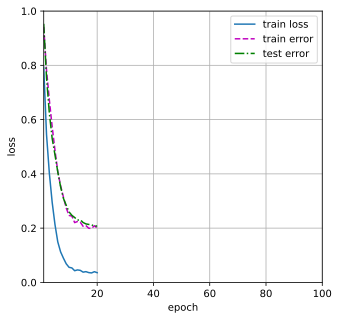

In [ ]:
if (test_env == 'notebook'):
  id_df = combined_dfs['NUMERIC_IDS']
  best_params['num_epochs'] = 100
  net, predictions, valid_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                 best_params,
                                                                 is_validation=True,
                                                                 early_stopping=True,
                                                                 visualize=True)
  print('Validation NRMSE:', round(100 * valid_nrmse, 2))
  pd_cv_preds = pd.DataFrame(data=predictions, columns=["id0", "id3", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_cv_preds = pd_cv_preds.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
  pd_cv_preds = pd_cv_preds[['COUNTRY', 'IDREGION', 'FYEAR', 'YIELD', 'YIELD_PRED']]

  countries = pd_cv_preds['COUNTRY'].unique()
  valid_info = '\nValidation Set NRMSEs'
  valid_info += '\n---------------------'
  for cn in countries:
    cn_preds_df = pd_cv_preds[pd_cv_preds['COUNTRY'] == cn]
    cn_nrmse = NormalizedRMSE(cn_preds_df['YIELD'].values,
                              cn_preds_df['YIELD_PRED'].values)
    valid_info += '\n' + crop + ', '  + cn + ' NRMSE:' + str(cn_nrmse)
    print('\n', crop, cn, 'Normalized RMSE:', cn_nrmse)
    print(cn_preds_df.head(10))

  log_fh.write(valid_info)
  saved_net_name = cyp_config['architecture'] + '-valid.net'
  torch.save(net.state_dict(), '/content/' + saved_net_name)

### Evaluate on test data

NRMSE: 0.1985
Test NRMSE: 19.85

 grain maize IT Normalized RMSE: 19.85271381745193
  COUNTRY IDREGION   FYEAR  YIELD  YIELD_PRED
0      IT    ITC11  2009.0   8.65   11.844118
1      IT    ITC11  2010.0   7.21   11.482216
2      IT    ITC11  2011.0   9.98   11.261084
3      IT    ITC11  2012.0  12.08   10.112122
4      IT    ITC11  2013.0   7.12   11.435083
5      IT    ITC12  2009.0   6.70    8.458152
6      IT    ITC12  2010.0   7.53    8.407700
7      IT    ITC12  2011.0   6.44    8.414865
8      IT    ITC12  2012.0   7.89    7.748648
9      IT    ITC12  2013.0   6.53    8.201807


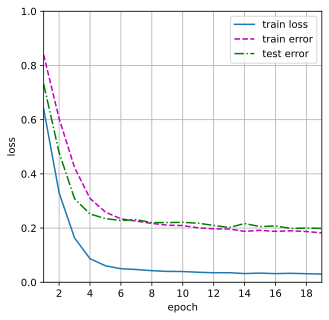

In [ ]:
if (test_env == 'notebook'):
  id_df = combined_dfs['NUMERIC_IDS']
  net, predictions, test_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                best_params,
                                                                is_validation=False,
                                                                early_stopping=False,
                                                                visualize=True)
  print('Test NRMSE:', round(100 * test_nrmse, 2))
  pd_test_preds = pd.DataFrame(data=predictions, columns=["id0", "id3", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_test_preds = pd_test_preds.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
  pd_test_preds = pd_test_preds[['COUNTRY', 'IDREGION', 'FYEAR', 'YIELD', 'YIELD_PRED']]

  countries = pd_test_preds['COUNTRY'].unique()
  test_info = '\nTest Set NRMSEs'
  test_info += '\n-----------------'
  for cn in countries:
    cn_preds_df = pd_test_preds[pd_test_preds['COUNTRY'] == cn]
    cn_nrmse = NormalizedRMSE(cn_preds_df['YIELD'].values,
                              cn_preds_df['YIELD_PRED'].values)
    test_info += '\n' + crop + ', '  + cn + ' NRMSE:' + str(cn_nrmse)
    print('\n', crop, cn, 'Normalized RMSE:', cn_nrmse)
    print(cn_preds_df.head(10))

  # Save predictions
  output_path = cyp_config['output_path']
  pred_file = getPredictionFilename(cyp_config['crop'],
                                    cyp_config['use_yield_trend'],
                                    cyp_config['early_season_end_dekad'],
                                    cyp_config['country_code'],
                                    cyp_config['spatial_level'],
                                    cyp_config['architecture'])

  pd_test_preds.to_csv(output_path + '/' + pred_file + '.csv', index=False)

  log_fh.write(test_info)
  saved_net_name = cyp_config['architecture'] + '-full.net'
  torch.save(net.state_dict(), '/content/' + saved_net_name)

### Evaluate Multiple Runs

[link text](https://)

#### Datasets

In [ ]:
test_fraction = cyp_config['test_fraction']
use_yield_trend = cyp_config['use_yield_trend']
early_season_end = cyp_config['early_season_end_dekad']
print_debug = cyp_config['debug_level'] > 1
num_valid_years = 5

scaler_args = {}
train_dataset = CYPMLDataset(combined_dfs,
                             yield_trend=use_yield_trend,
                             early_season_end=early_season_end,
                             is_train=True,
                             test_fraction=test_fraction,
                             num_folds=1, fold_iter=0,
                             num_valid_years=5,
                             scaler_args=scaler_args,
                             country=country,
                             print_debug=print_debug,
                             log_fh=log_fh)

valid_dataset = CYPMLDataset(combined_dfs,
                             early_season_end=early_season_end,
                             is_train=False, is_validation=True,
                             test_fraction=test_fraction,
                             num_folds=1, fold_iter=0,
                             num_valid_years=5,
                             scaler_args=scaler_args,
                             country=country,
                             print_debug=print_debug,
                             log_fh=log_fh)

scaler_args = {}
test_years = None
# if ((crop == 'soft wheat') and (country == 'FR')):
#   test_years = [2017]

train_dataset2 = CYPMLDataset(combined_dfs,
                              yield_trend=use_yield_trend,
                              early_season_end=early_season_end,
                              is_train=True,
                              test_fraction=test_fraction,
                              num_folds=1, fold_iter=0,
                              num_valid_years=0,
                              scaler_args=scaler_args,
                              country=country, test_years=test_years,
                              print_debug=print_debug,
                              log_fh=log_fh)

test_dataset = CYPMLDataset(combined_dfs,
                            early_season_end=early_season_end,
                            is_train=False, is_validation=False,
                            test_fraction=test_fraction,
                            num_folds=1, fold_iter=0,
                            num_valid_years=0,
                            scaler_args=scaler_args,
                            country=country, test_years=test_years,
                            print_debug=print_debug,
                            log_fh=log_fh)

datasets = {
    'valid' : [train_dataset, valid_dataset],
    'test' : [train_dataset2, test_dataset]
}


----------------
Training data
----------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, RSM, TMIN, TMAX, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA2, AEZ_1960, AEZ_1984, AEZ_2030, AEZ_2107, AEZ_2150
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

IT Training years: 2000, 2001, 2002, 2003


Dekadal data: 265, 30, 10
Other feature data: 70, 15
Trend feature data: 265, 5
Label data: 265, 4

------------------
Validation data
------------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, RSM, TMIN, TMAX, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA2, AEZ_1960, AEZ_1984, AEZ_2030, AEZ_2107, AEZ_2150
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

IT Validation years: 2004, 2005, 2006, 2007, 2008


Dekadal data: 335

#### Training and Evaluation

In [ ]:
def trainAndTest(cyp_config, best_params,
                 train_dataset, test_dataset,
                 early_stopping=False,
                 pretrained=False, saved_net=None,
                 visualize=False, country=None):
  """
  1. Evaluate on validation data: num_valid_years = 5
  2. Evaluate on test data: num_valid_years = 0.
  """
  loss = nn.MSELoss()
  num_epochs = best_params['num_epochs']
  architecture = cyp_config['architecture']

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'],
                                             shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params['batch_size'],
                                            shuffle=False, num_workers=2)

  y_max = 1.0 # torch.max(train_dataset[0][3]).item()/2
  # train_dataset is : X_ts, X_rest, X_trend. X_rest shape is (variables)
  num_other_features = train_dataset[0][1].shape[0]
  # X_trend shape is (trend_window)
  num_trend_features = train_dataset[0][2].shape[0]

  # X_ts shape is (dekads, variables)
  ts_seq_len = train_dataset[0][0].shape[0]
  num_ts_indicators = train_dataset[0][0].shape[1]

  device = d2l.try_gpu()
  assert architecture in ['1DCNN', 'LSTM'], 'Architecture is not supported. Must be 1DCNN or LSTM.'
  if (architecture == '1DCNN'):
    net = CYP1DCNNModel(num_ts_indicators,
                        num_trend_features,
                        num_other_features,
                        ts_seq_len=ts_seq_len,
                        num_outputs=1)
  elif (architecture == 'LSTM'):
    net = CYPLSTMModel(num_ts_indicators,
                       num_trend_features,
                       num_other_features,
                       ts_seq_len=ts_seq_len,
                       num_outputs=1)

  net = net.to(device)
  if (pretrained):
    net.load_state_dict(torch.load(saved_net))

  trainer = torch.optim.Adam(net.parameters(), lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

  test_nrmse, epochs_run = train(net, train_loader, test_loader, loss, trainer, num_epochs,
                                 early_stopping=early_stopping, device=device,
                                 country=country, visualize=visualize, ymax=y_max)

  if (early_stopping):
    best_params['num_epochs'] = epochs_run

  print('NRMSE:', round(test_nrmse, 4))
  predictions, test_nrmse = evaluatePredictions(net, test_loader, device)

  return net, predictions, test_nrmse

#### Evaluate Multiple Runs

In [ ]:
import pandas as pd

num_iters = 10
pd_cv_preds_all = None
pd_test_preds_all = None
static_ft_names = None
trend_ft_names = None
for i in range(1, num_iters + 1):
  """
  Evaluate on validation data with early stopping
  """
  iter_info = '\n' + 'Iteration ' + str(i)
  iter_info += '\n-------------------'
  print(iter_info)
  log_fh.write(iter_info)

  id_df = combined_dfs['NUMERIC_IDS']
  best_params['num_epochs'] = 100
  valid_info = '\n\nValidation Set Evaluation'
  valid_info += '\n----------------------------'
  print(valid_info)
  net, predictions, valid_nrmse = trainAndTest(cyp_config, best_params,
                                               datasets['valid'][0], datasets['valid'][1],
                                               early_stopping=True, visualize=False)
  valid_info = '\nValidation NRMSE:' + str(round(100 * valid_nrmse, 3))
  pd_cv_preds = pd.DataFrame(data=predictions, columns=["id0", "id3", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_cv_preds = pd_cv_preds.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
  pd_cv_preds = pd_cv_preds[['COUNTRY', 'IDREGION', 'FYEAR', 'YIELD', 'YIELD_PRED']]

  if (pd_cv_preds_all is None):
    pd_cv_preds_all = pd_cv_preds
  else:
    pd_cv_preds_all = pd_cv_preds_all.append(pd_cv_preds)

  countries = pd_cv_preds['COUNTRY'].unique()
  valid_info += '\n\nValidation NRMSEs'
  valid_info += '\n---------------------'
  for cn in countries:
    cn_preds_df = pd_cv_preds[pd_cv_preds['COUNTRY'] == cn]
    cn_nrmse = NormalizedRMSE(cn_preds_df['YIELD'].values,
                              cn_preds_df['YIELD_PRED'].values)
    valid_info += '\n' + crop + ', '  + cn + ' NRMSE:' + str(cn_nrmse)

  print(valid_info)
  log_fh.write(valid_info)

  """
  Evaluate on test data with early stopping epochs from above
  """
  id_df = combined_dfs['NUMERIC_IDS']
  test_info = '\n\nTest Set Evaluation'
  test_info += '\n----------------------------'
  print(test_info)
  net, predictions, test_nrmse = trainAndTest(cyp_config, best_params,
                                              datasets['test'][0], datasets['test'][1],
                                              early_stopping=False, visualize=False)
  test_info = '\nTest NRMSE: ' + str(round(100 * test_nrmse, 2))
  pd_test_preds = pd.DataFrame(data=predictions, columns=["id0", "id3", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_test_preds = pd_test_preds.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
  pd_test_preds = pd_test_preds[['COUNTRY', 'IDREGION', 'FYEAR', 'YIELD', 'YIELD_PRED']]

  if (pd_test_preds_all is None):
    pd_test_preds_all = pd_test_preds
  else:
    pd_test_preds_all = pd_test_preds_all.append(pd_test_preds)

  countries = pd_test_preds['COUNTRY'].unique()
  test_info += '\n\nTest NRMSEs'
  test_info += '\n-----------------'
  for cn in countries:
    cn_preds_df = pd_test_preds[pd_test_preds['COUNTRY'] == cn]
    cn_nrmse = NormalizedRMSE(cn_preds_df['YIELD'].values,
                              cn_preds_df['YIELD_PRED'].values)
    test_info += '\n' + crop + ', '  + cn + ' NRMSE:' + str(cn_nrmse)

  print(test_info)
  log_fh.write(test_info)

# Save predictions
output_path = cyp_config['output_path']
pred_file = getPredictionFilename(cyp_config['crop'],
                                  cyp_config['use_yield_trend'],
                                  cyp_config['early_season_end_dekad'],
                                  cyp_config['country_code'],
                                  cyp_config['spatial_level'],
                                  cyp_config['architecture'])

pd_test_preds_all.to_csv(output_path + '/' + pred_file + '-mul.csv', index=False)

valid_info = '\n\nAverage Validation Set NRMSEs'
valid_info += '\n----------------------------'
countries = sorted(pd_cv_preds_all['COUNTRY'].unique())
for cn in countries:
  pd_cn_cv_preds = pd_cv_preds_all[pd_cv_preds_all['COUNTRY'] == cn]
  pd_cn_cv_preds = pd_cn_cv_preds.groupby(['IDREGION', 'FYEAR']).agg(YIELD_PRED=('YIELD_PRED', 'mean'),
                                                                     YIELD=('YIELD', 'mean' )).reset_index()
  cn_nrmse = round(NormalizedRMSE(pd_cn_cv_preds['YIELD'].values,
                                  pd_cn_cv_preds['YIELD_PRED'].values), 3)
  valid_info += '\n' + crop + ', '  + cn + ': ' + str(cn_nrmse)

print(valid_info)
log_fh.write(valid_info)

test_info = '\n\nAverage Test Set NRMSEs'
test_info += '\n----------------------------'
countries = sorted(pd_test_preds_all['COUNTRY'].unique())
for cn in countries:
  pd_cn_test_preds = pd_test_preds_all[pd_test_preds_all['COUNTRY'] == cn]
  pd_cn_test_preds = pd_cn_test_preds.groupby(['IDREGION', 'FYEAR']).agg(YIELD_PRED=('YIELD_PRED', 'mean'),
                                                                         YIELD=('YIELD', 'mean' )).reset_index()
  cn_nrmse = round(NormalizedRMSE(pd_cn_test_preds['YIELD'].values,
                                  pd_cn_test_preds['YIELD_PRED'].values), 3)
  
  test_info += '\n' + crop + ', '  + cn + ': ' + str(cn_nrmse)

log_fh.write(test_info)
print(test_info)


Iteration 1
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.2339

Validation NRMSE:23.388

Validation NRMSEs
---------------------
grain maize, IT NRMSE:23.38835862154031


Test Set Evaluation
----------------------------
NRMSE: 0.1995

Test NRMSE: 19.95

Test NRMSEs
-----------------
grain maize, IT NRMSE:19.9478776832113

Iteration 2
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.2164

Validation NRMSE:21.638

Validation NRMSEs
---------------------
grain maize, IT NRMSE:21.638056724763146


Test Set Evaluation
----------------------------
NRMSE: 0.2009

Test NRMSE: 20.09

Test NRMSEs
-----------------
grain maize, IT NRMSE:20.09155240984742

Iteration 3
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.2526

Validation NRMSE:25.26

Validation NRMSEs
---------------------
grain maize, IT NRMSE:25.259650811863597


Test Set Evaluation
----------------------------
NRMSE: 0.

### Close file handle

In [ ]:
log_fh.close()

# ! mv *.csv *.log drive/MyDrive/Wageningen\ PhD/Dilli\ -\ Deep\ Learning/saved-output/combo-early-6
! mv *.csv *.log drive/MyDrive/Wageningen\ PhD/Dilli\ -\ Deep\ Learning/saved-output/per-country-early-6

# change the last directory before running
#! mv *.jpg *.csv *.log drive/MyDrive/Wageningen\ PhD/Dilli\ -\ Deep\ Learning/saved-output/soft-wheat-FR-end-LSTM